# DMS Level 1b Example

## HR 8799 GTO 1194 

This program will search for previously unknown planets using NIRCam in the F356W and F444W filters using the MASK430R for both filters. In addition, we will probe the physical characterization of the known planets, HR8789bcde, using multi-filter photometry with the LW Bar mask. The medium-band filters will be observed with a fiducial override to place the primary source on the narrow end of the occulting mask. The NIRCam observations will use two roll angles ($\pm5$ deg) and a reference star to assist with suppression of residuals in the coronagraphic image.

This notebook uses output from the APT file of PID 1194 to simulate the obsevations and save them to DMS-like FITS files (Level 1b data).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc.simul.ngNRC import create_level1b_FITS

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time
from astropy.table import Table

In [4]:
import os

import pynrc
from pynrc import nrc_utils
from pynrc.simul.ngNRC import make_gaia_source_table, make_simbad_source_table
from pynrc.simul.ngNRC import create_level1b_FITS

pynrc.setup_logging('WARN', verbose=False)

## APT Inputs

From the final APT file, we need to export a number of files, including the `.timing.json`, `.smart_accounting`, `.pointing`, and `.xml` files. These are then parsed by `pynrc` to configure a series of observation visits and associated NIRCam objects.

In [5]:
import os

# Read in APT
pid = 1194
pid_str = f'pid{pid:05d}'

save_dir = f'/Users/jarron/NIRCam/Data/NRC_Sims/Sim_{pid_str}/'
# save_dir = f'/data/NIRData/NRC_Sims/Sim_{pid_str}/'

# APT input files
apt_file_dir = '../../notebooks/APT_output/'
fprefix = f'pid{pid}'
json_file     = f'{apt_file_dir}{fprefix}.timing.json'
sm_acct_file  = f'{apt_file_dir}{fprefix}.smart_accounting'
pointing_file = f'{apt_file_dir}{fprefix}.pointing'
xml_file      = f'{apt_file_dir}{fprefix}.xml'

# Make sure files exist
for f in [json_file, sm_acct_file, pointing_file, xml_file]:
    print(f, os.path.isfile(f))

../../notebooks/APT_output/pid1194.timing.json True
../../notebooks/APT_output/pid1194.smart_accounting True
../../notebooks/APT_output/pid1194.pointing True
../../notebooks/APT_output/pid1194.xml True


## Source Definitions

We will utilize the `source_spectrum` class to generate a model fit to the known spectrophotometry. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

The output spectra will then be placed into a target dictionary to be ingested into the DMS simulator portion of pyNRC.

In [6]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science    source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sci = ('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)

# References  source,     sptype, Teff, [Fe/H], log_g, mag, band
args_ref = ('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = '../../notebooks/votables/'

In [7]:
# Fit spectrum to SED photometry
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sci
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = pynrc.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=False, wlim=[1,5])

# Final source spectrum (pysynphot)
sp_sci = src.sp_model

[0.98590364]


In [8]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = args_ref
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = pynrc.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=False, wlim=[0.5,10])

# Final reference spectrum (pysynphot)
sp_ref = ref.sp_model

[1.07580856]


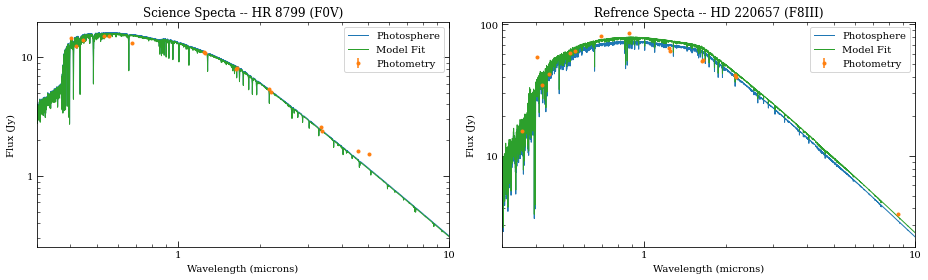

In [9]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4))
src.plot_SED(xr=[0.3,10], ax=axes[0])
ref.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

## Target Information

For each target specified in the APT file, we want to populate a dictionary with coordinate information and astrophysical properties. The dictionary keys should match the APT "Name in the Proposal" so that 

For each designated target, there are four types of objects that can be added: stellar source, point source companions, disk object, and/or a table of point sources specifying magnitudes in NIRCam filters.

1. Stellar source:
``` python
params_star = {
    'sptype' : 'A0V', 'Teff': 10325, 'metallicity' : 0, 'log_g' : 4.09,
    'v_mag' : 5.690, 'j_mag': 5.768, 'h_mag': 5.753, 'k_mag': 5.751,
},
```
to generate a spectrum using `pynrc.stellar_spectrum` or add the parameter directly
``` python
    params_star = {'sp' : sp_star}
```

2. Companions (where `bp_renorm` is a `pysynphot` bandpass):
``` python
    params_hci_companions = {
        'b' : {'xy':(-1.625,  0.564), 'runits':'arcsec', 'renorm_args':(16.0, 'vegamag', bp_renorm)},
        'c' : {'xy':( 0.319,  0.886), 'runits':'arcsec', 'renorm_args':(15.0, 'vegamag', bp_renorm)},
        'd' : {'xy':( 0.588, -0.384), 'runits':'arcsec', 'renorm_args':(14.6, 'vegamag', bp_renorm)},
        'e' : {'xy':( 0.249,  0.294), 'runits':'arcsec', 'renorm_args':(14.7, 'vegamag', bp_renorm)},
    }
```
See `obs_hci.add_planet()` function for more information and advanced functionality. 

3. Companion disk model:
``` python
    params_disk_model = {
        'file': 'HD10647.fits',  # path to file
        'wavelength': 3.0,       # model wavelength (um)
        'pixscale': 0.01575,     # input image arcsec/pixel
        'units': 'Jy/pixel',     # model flux units (e.g., mJy/arcsec, Jy/pixel, etc)
        'dist': 17.34,           # assumed distance to model (pc)
        'cen_star': True,        # does the model include stellar flux?
    }
```

4. Table of stellar sources:
``` python
    from astropy.io import ascii
    
    cat_file = 'lmc_catalog.cat'
    names = [
        'index', 'ra', 'dec', 'F070W', 'F090W', 'F115W', 'F140M', 'F150W', 'F150W2',
        'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 
        'F300M','F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 
        'F444W', 'F460M', 'F466N', 'F470N', 'F480M'
    ]

    src_tbl = ascii.read(cat_file, names=names)
```
Use `make_gaia_source_table` and `make_simbad_source_table` to query Gaia DR2 and Simbad to auto-generate tables.

In [10]:
# Initialize target dictionary
targ_dict = {}

# Bandpass corresponding to companion renormalization flux
bp_pl_norm = pynrc.read_filter('F430M')
# Assumed companion magnitudes in filter bandpass
comp_mags = np.array([16.0, 15.0, 14.6, 14.7])

# Dictionary keywords should match APT target names
targ_dict['HR8799'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HR8799', 'TargetArchiveName' : 'HR8799',
    'EquatorialCoordinates' : "23 07 28.7155 +21 08 3.30",
    'RAProperMotion'  : 108.551*u.mas/u.yr, 
    'DecProperMotion' : -49.639*u.mas/u.yr, 
    'parallax' : 24.76*u.mas, 'age_Myr' : 30,
    'params_star' : {'sp' : sp_sci},
    'params_companions' : {
        'b' : {'xy':(-1.625,  0.564), 'runits':'arcsec', 'mass':10,
               'renorm_args':(comp_mags[0], 'vegamag', bp_pl_norm)
              },
        'c' : {'xy':( 0.319,  0.886), 'runits':'arcsec', 'mass':10, 
               'renorm_args':(comp_mags[1], 'vegamag', bp_pl_norm)
              },
        'd' : {'xy':( 0.588, -0.384), 'runits':'arcsec', 'mass':10, 
               'renorm_args':(comp_mags[2], 'vegamag', bp_pl_norm)
              },
        'e' : {'xy':( 0.249,  0.294), 'runits':'arcsec', 'mass':10, 
               'renorm_args':(comp_mags[3], 'vegamag', bp_pl_norm)
              },
    },
    'params_disk_model' : None,
    'src_tbl' : None,
}

In [11]:
# Reference source
targ_dict['HD220657'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HD220657', 'TargetArchiveName' : 'ups Peg',
    'EquatorialCoordinates' : "23 25 22.7835 +23 24 14.76",
    'RAProperMotion'  : 192.19*u.mas/u.yr, 
    'DecProperMotion' : 36.12*u.mas/u.yr, 
    'parallax' : 19.14*u.mas, 'age_Myr' : None,
    'params_star' : {'sp' : sp_ref},
    'params_companions' : None,
    'params_disk_model' : None,
    'src_tbl' : None,
}

In [12]:
# Populate coordinates and calculate distance from parallax info
for k in targ_dict.keys():
    d = targ_dict[k]
    dist = Distance(parallax=d['parallax']) if d['parallax'] is not None else None
    c = SkyCoord(d['EquatorialCoordinates'], frame='icrs', unit=(u.hourangle, u.deg),
                 pm_ra_cosdec=d['RAProperMotion'], pm_dec=d['DecProperMotion'],
                 distance=dist, obstime='J2000')
    d['sky_coords'] = c
    d['ra_J2000'], d['dec_J2000'] = (c.ra.deg, c.dec.deg)
    d['dist_pc'] = c.distance.value if dist is not None else None
    
    # Auto-generate source tables
    src_tbl = make_gaia_source_table(c)
    d['src_tbl'] = src_tbl if len(src_tbl)>0 else None

INFO: Query finished. [astroquery.utils.tap.core]
[astroquery:INFO] Query finished.


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]
[astroquery:INFO] Query finished.


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

## Create Observation Parameters

These will used for input into the data ramp simulator and directly correspond to parameters for DMS FITS creation to ingest into the JWST pipeline

In [13]:
sim_config = {
    # APT input files
    'json_file'     : json_file,
    'sm_acct_file'  : sm_acct_file,
    'pointing_file' : pointing_file,
    'xml_file'      : xml_file,
    # Output directory
    'save_dir'      : save_dir,
    
    # Initialize random seeds if repeatability is required
    # Create separate random number generators for dithers and noise
    'rand_seed_init'  : 1234,
    
    # Date and time of observations
    'obs_date' : '2022-11-04', 
    'obs_time' : '12:00:00',
    # Position angle of observatory
    # User should check acceptable range in APT's Roll Analysis
    'pa_v3'    : 90.0,
    
    # Source information
    'params_targets' : targ_dict,
    
    # PSF size information for WebbPSF_ext
    'params_webbpsf' : {'fov_pix': None, 'oversample': 2},
    # Position-dependent PSFs for convolution
    'params_psfconv' : {'npsf_per_full_fov': 9, 'osamp': 1, 'sptype': 'G0V'},
    # Wavefront error drift settings
    'params_wfedrift' : {'case': 'BOL', 'slew_init': 10, 'plot': False, 'figname': None},
    # For coronagraphic masks, sample large grid of points?
    'large_grid' : True,
    
    # Slew and dither pointing uncertainties
    'large_slew' : 100.0,   # Slew to target (mas)
    'ta_sam'     : 5.0,     # SAM movements from TA position (mas)
    'std_sam'    : 5.0,     # Standard dither values (mas)
    'sgd_sam'    : 2.5,     # Small grid dithers (mas)
    
    # Type of image files to save; can be supplied directly
    'save_slope' : False,  # Save ideal noiseless slope images to FITS
    'save_dms'   : False,  # Save DMS-like ramps to FITS
    'dry_run'    : False,  # Perform a dry-run, not generating any data, just printing visit info
    
    # Noise components to include in full DMS output
    'params_noise' : {
        'include_poisson'   : True,     # Photon Noise
        'include_dark'      : True,     # Dark current
        'include_bias'      : True,     # Bias image offset
        'include_ktc'       : True,     # kTC Noise
        'include_rn'        : True,     # Read Noise
        'include_cpink'     : True,     # Correlated 1/f noise between channel
        'include_upink'     : True,     # Channel-dependent 1/f noise
        'include_acn'       : True,     # Alternating column noise
        'apply_ipc'         : True,     # Interpixel capacitance
        'apply_ppc'         : True,     # Post-pixel coupling
        'amp_crosstalk'     : True,     # Amplifier crosstalk
        'include_refoffsets': True,     # Reference offsets
        'include_refinst'   : True,     # Reference pixel instabilities
        'include_colnoise'  : True,     # Transient detector column noise
        'add_crs'           : True,     # Include cosmic ray
        'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
        'cr_scale'          : 1,        # Cosmic ray probabilities scaling
        'apply_nonlinearity': True,     # Apply non-linearity
        'random_nonlin'     : True,     # Add randomness to non-linearity
        'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
    },
}

## Perform simulations of observations

The next few cells demonstrate how to simulate observations for a single visit in the program (`001:001`). In order to generate a subset of observations, the `create_level1b_FITS` function has a few keyword settings, including `visit_id`, `apname`, `filter`, and `detname`. 

In addition, there are some diagnostic-level options to ensure simulations are being generated as expected before going through the long process of making everything.  makes sense during

 * `dry_run`: Won't generate any image data, but instead runs through each observation, printing detector info, SIAF aperture name, filter, visit IDs, exposure numbers, and dither information. If set to `None`, then grabs keyword from `sim_config` argument, otherwise defaults to `False` if not specified. If paired with `save_dms`, then will generate an empty set of DMS FITS files with headers populated, but data set to all zeros.
 * `save_slope`: Saves noiseless slope images to a separate DMS-like FITS file that is names `slope_{DMSfilename}`. If set to `None`, then grabs keyword from `sim_config`, otherwise defaults to False if not found. **Is  effect if `dry_run=True`.**
 * `save_dms`: Option to disable simulation of ramp data and creation of DMS FITS. If `dry_run=True`, then setting `save_dms=True` will save DMS FITS files populated with all zeros. If set to `None`, then grabs keyword from `sim_config`; if no keyword is found, then defaults to `True` if `dry_run=False`, otherwise False.


In [14]:
# Perform dry-run test first
# prints (detname, aperture, filter, target, visit, grp/seq/act id, expid, offset, dWFE, dtime start)
create_level1b_FITS(sim_config, dry_run=True, save_slope=False, save_dms=False, 
                    visit_id='001:001')

Obs Params:   0%|          | 0/70 [00:00<?, ?it/s]

Exposures:   0%|          | 0/5 [00:00<?, ?it/s]

NRCA5 NRCA5_FULL_MASK430R F335M HR8799 001:001 03104 1 (+0.003, -0.005) 1.84 2915


Exposures:   0%|          | 0/5 [00:00<?, ?it/s]

NRCA5 NRCA5_FULL_TAMASK430R F335M HR8799 001:001 03102 1 (+0.020, -0.017) 1.86 2720


Exposures:   0%|          | 0/5 [00:00<?, ?it/s]

NRCA5 NRCA5_MASK430R F356W HR8799 001:001 03106 1 (+0.003, -0.005) 1.92 3107


Exposures:   0%|          | 0/5 [00:00<?, ?it/s]

NRCA5 NRCA5_MASK430R F444W HR8799 001:001 03107 1 (+0.003, -0.005) 1.95 3706


Exposures:   0%|          | 0/5 [00:00<?, ?it/s]

NRCA5 NRCA5_TAMASK430R F335M HR8799 001:001 02102 1 (+0.020, -0.017) 1.86 2536


In [ ]:
# Create ideal slope images, saved to Level-1b formation
# Will print messages: 
#   Saving: slope_jw01194001001_03104_00001_nrca5_uncal.fits
create_level1b_FITS(sim_config, dry_run=False, save_slope=True, save_dms=False, 
                    visit_id='001:001')

In [ ]:
# Generate simulated Level-1b FITS files
# Will print messages: 
#   Saving: pynrc_jw01194001001_03106_00001_nrca5_uncal.fits
create_level1b_FITS(sim_config, dry_run=False, save_slope=False, save_dms=True, 
                    visit_id='001:001', apname='NRCA5_MASK430R')